In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics as sk_metrics
from sklearn.metrics import classification_report

import data
import uncertainty_estimation as ue
from main_bayesian import getModel
import config_bayesian as cfg
import utils
import torch
import metrics
from torch.nn import functional as F
import config_bayesian as cfg
import pandas as pd


/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)
print(torch.cuda.device_count())
print(torch.version.cuda) 

True
cuda:0
1
11.0


In [3]:
source = cfg.source # 0: work computer, 1: laptop. NOTE: also change in data.py
print(source)

0


## OOD Detection

In [4]:
trainsetOOD, testsetOOD, inputs, num_classes = data.getDataset('OOD')
train_loaderOOD, valid_loaderOOD, test_loaderOOD = data.getDataloader(trainsetOOD, testsetOOD, cfg.valid_size, batch_size=1, num_workers=cfg.num_workers)

trainset, testset, inputs, num_classes = data.getDataset('POCUS')
train_loader, valid_loader, test_loader = data.getDataloader(trainset, testset, cfg.valid_size, batch_size=1, num_workers=cfg.num_workers)
train_combo, test_combo, inputs, num_classes = data.getDataset('OOD_combo')
_, _, combo_loader = data.getDataloader(train_combo, test_combo, cfg.valid_size, batch_size=1, num_workers=cfg.num_workers)

#ckpt_name = 'model_custom_bbb_relu_2023-10-19_2VP1X'
#ckpt_name = 'model_custom_bbb_relu_2023-10-19_NTQ4K' # this one performs pretty bad, however the UQ for begnin and malignant is very different between the OOD and the POCUS datasets (Which is really good!)
#ckpt_name = 'model_custom_bbb_relu_2023-10-30_OVJ7I'
ckpt_name = 'model_custom_bbb_relu_2023-10-30_1OK53'
net_type = 'custom' # 'alexnet'

loc_pc = '/home/marisa/Documents'
loc_lap = 'C:/Users/maris/Documents/Thesis'
locs = [loc_pc, loc_lap]
loc = locs[source]

# Load model
ckpt = f'{loc}/PyTorch-BayesianCNN/checkpoints/POCUS/bayesian/{ckpt_name}.pt'
layer_type = cfg.layer_type
activation_type = cfg.activation_type

net = getModel(net_type, inputs, num_classes, priors=None, layer_type=layer_type, activation_type=activation_type)
net = net.to(device)
net.load_state_dict(torch.load(ckpt, map_location=device)["model_state_dict"])
net.train() # should this be train or eval?

found data in  /home/marisa/Documents/Thesis/Data/OOD-examples/  :  8
length of train set:  8
found data in  /home/marisa/Documents/Thesis/Data/OOD-examples/  :  8
found data in  /home/marisa/Documents/Thesis/Data/POCUS_and_US/Train/  :  1236
found data in  /home/marisa/Documents/Thesis/Data/POCUS_and_US/Test/  :  531
files in test_dir:  ['/home/marisa/Documents/Thesis/Data/DATA_FOR_ISBI/Combo/Benign', '/home/marisa/Documents/Thesis/Data/DATA_FOR_ISBI/Combo/Normal', '/home/marisa/Documents/Thesis/Data/DATA_FOR_ISBI/Combo/Malignant']
found data in  /home/marisa/Documents/Thesis/Data/DATA_FOR_ISBI/Combo/  :  531
found data in  /home/marisa/Documents/Thesis/Data/DATA_FOR_ISBI/Combo/  :  531
length of OOD set:  531


BBBCustom(
  (conv1): BBBConv2d()
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): BBBConv2d()
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): BBBConv2d()
  (act3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): BBBConv2d()
  (act4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): BBBConv2d()
  (act5): ReLU()
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): FlattenLayer()
  (fc1): BBBLinear()
  (act6): ReLU()
  (fc2): BBBLinear()
)

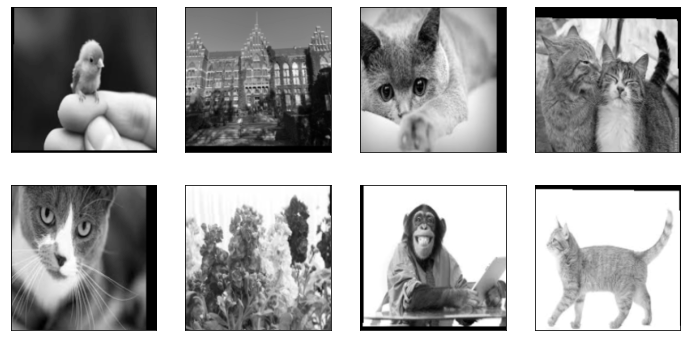

In [5]:
# plot all images in OOD test set
fig = plt.figure(figsize=(12,6))
rows, cols = 2,4


for i, (inputs, targets) in enumerate(test_loaderOOD):

   fig.add_subplot(rows, cols, i+1)
   plt.imshow(inputs.squeeze(), cmap='gray')
   plt.xticks([])
   plt.yticks([])
plt.show()


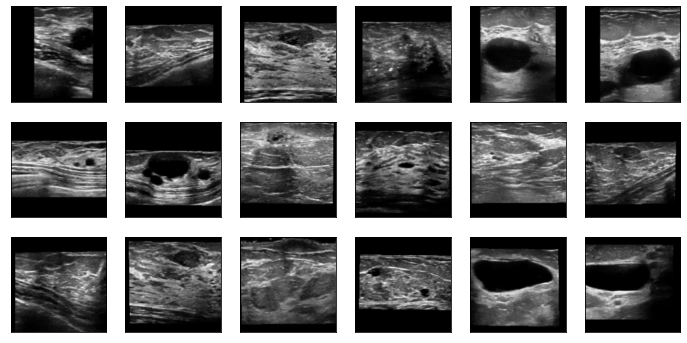

In [6]:
# plot some images in POCUS test set
fig = plt.figure(figsize=(12,6))
rows, cols = 3,6

for i in range(18):

   inputs, targets = test_loader.dataset[i]
   fig.add_subplot(rows, cols, i+1)
   plt.imshow(inputs.squeeze(), cmap='gray')
   plt.xticks([])
   plt.yticks([])
plt.show()

In [11]:
def evaluate_uncertainties(net, testset):

    n_samples = len(testset)
    
    uncertainties = []

    for idx in range(n_samples):
        sample, truth = testset[idx]
        sample = sample.to(device)

        pred, epi_norm, ale_norm = ue.get_uncertainty_per_image(net, sample, T=32, normalized=True)
        pred, epi_soft, ale_soft = ue.get_uncertainty_per_image(net, sample, T=32, normalized=False)

        pred = int(np.argmax(pred))
        uncertainties.append([epi_norm[0], 
                              epi_norm[1],
                              epi_norm[2],
                              ale_norm[0],
                              ale_norm[1],
                              ale_norm[2], 
                              epi_soft[0], 
                              epi_soft[1], 
                              epi_soft[2], 
                              ale_soft[0], 
                              ale_soft[1], 
                              ale_soft[2], 
                              epi_norm[pred],
                              ale_norm[pred],
                              epi_soft[pred],
                              ale_soft[pred],
                              truth==pred, 
                              truth, 
                              pred
                              ])


    return uncertainties

In [12]:
uncertainties_OOD = evaluate_uncertainties(net, testsetOOD)
df_OOD = pd.DataFrame(uncertainties_OOD, columns=['epi_norm_0', 'epi_norm_1', 'epi_norm_2', 'ale_norm_0', 'ale_norm_1', 'ale_norm_2', 'epi_soft_0', 'epi_soft_1', 'epi_soft_2', 'ale_soft_0', 'ale_soft_1', 'ale_soft_2', 'epi_norm_pred', 'ale_norm_pred', 'epi_soft_pred', 'ale_soft_pred', 'correct', 'truth', 'pred'])

In [13]:
uncertainties_POCUS = evaluate_uncertainties(net, testset)
df_POCUS = pd.DataFrame(uncertainties_POCUS, columns=['epi_norm_0', 'epi_norm_1', 'epi_norm_2', 'ale_norm_0', 'ale_norm_1', 'ale_norm_2', 'epi_soft_0', 'epi_soft_1', 'epi_soft_2', 'ale_soft_0', 'ale_soft_1', 'ale_soft_2', 'epi_norm_pred', 'ale_norm_pred', 'epi_soft_pred', 'ale_soft_pred', 'correct', 'truth', 'pred'])

In [14]:
uncertainties_OOD_combo = evaluate_uncertainties(net, test_combo)
df_OOD_combo = pd.DataFrame(uncertainties_OOD_combo, columns=['epi_norm_0', 'epi_norm_1', 'epi_norm_2', 'ale_norm_0', 'ale_norm_1', 'ale_norm_2', 'epi_soft_0', 'epi_soft_1', 'epi_soft_2', 'ale_soft_0', 'ale_soft_1', 'ale_soft_2', 'epi_norm_pred', 'ale_norm_pred', 'epi_soft_pred', 'ale_soft_pred', 'correct', 'truth', 'pred'])

In [ ]:
df_OOD.describe()

,epi_norm_0,epi_norm_1,epi_norm_2,ale_norm_0,ale_norm_1,ale_norm_2,epi_soft_0,epi_soft_1,epi_soft_2,ale_soft_0,ale_soft_1,ale_soft_2,epi_norm_pred,ale_norm_pred,epi_soft_pred,ale_soft_pred,truth,pred
count,8.000000e+00,8.000000e+00,8.000000e+00,8.000000,8.000000,8.000000,8.000000e+00,8.000000e+00,8.000000e+00,8.000000,8.000000,8.000000,8.000000e+00,8.000000,8.000000e+00,8.000000,8.0,8.000000
mean,8.659740e-15,4.606775e-16,5.578871e-15,0.217004,0.086485,0.212929,2.445266e-14,2.128492e-16,1.016548e-14,0.192811,0.033902,0.187309,9.436896e-15,0.225949,3.064216e-14,0.197224,0.0,1.000000
std,1.128221e-14,6.869933e-16,5.651632e-15,0.038160,0.054445,0.045387,3.266017e-14,4.777680e-16,1.897961e-14,0.046653,0.033405,0.055244,1.071022e-14,0.026803,3.359348e-14,0.046244,0.0,1.069045
min,0.000000e+00,0.000000e+00,0.000000e+00,0.133324,0.011566,0.138022,0.000000e+00,5.421011e-20,8.881784e-16,0.106712,0.001444,0.104014,0.000000e+00,0.178676,0.000000e+00,0.106712,0.0,0.000000
25%,0.000000e+00,5.854692e-18,2.664535e-15,0.209916,0.058943,0.175050,2.886580e-15,1.138412e-18,3.011480e-15,0.167853,0.003445,0.168375,2.664535e-15,0.209916,3.552714e-15,0.184152,0.0,0.000000
50%,4.440892e-15,2.220446e-16,3.552714e-15,0.220274,0.082218,0.238094,6.772360e-15,3.165870e-17,3.552714e-15,0.196303,0.028149,0.194283,5.773160e-15,0.232111,1.776357e-14,0.196630,0.0,1.000000
75%,1.421085e-14,4.822531e-16,7.716050e-15,0.248096,0.107520,0.247463,3.819167e-14,1.249001e-16,4.662937e-15,0.225701,0.059149,0.225715,1.421085e-14,0.248762,5.684342e-14,0.227920,0.0,2.000000
max,3.197442e-14,1.998401e-15,1.421085e-14,0.249144,0.189301,0.249966,8.881784e-14,1.387779e-15,5.684342e-14,0.248373,0.086235,0.249675,3.197442e-14,0.249966,8.881784e-14,0.249675,0.0,2.000000


In [ ]:
df_POCUS.describe()

,epi_norm_0,epi_norm_1,epi_norm_2,ale_norm_0,ale_norm_1,ale_norm_2,epi_soft_0,epi_soft_1,epi_soft_2,ale_soft_0,ale_soft_1,ale_soft_2,epi_norm_pred,ale_norm_pred,epi_soft_pred,ale_soft_pred,truth,pred
count,5.310000e+02,5.310000e+02,5.310000e+02,531.000000,531.000000,531.000000,5.310000e+02,5.310000e+02,5.310000e+02,531.000000,531.000000,531.000000,5.310000e+02,531.000000,5.310000e+02,531.000000,531.000000,531.000000
mean,9.626010e-15,3.766761e-15,9.336981e-15,0.221304,0.168863,0.216689,1.279984e-14,3.905000e-15,1.005003e-14,0.194073,0.137499,0.191953,1.079154e-14,0.226452,2.054017e-14,0.223395,0.681733,0.902072
std,1.193662e-14,5.631495e-15,1.249573e-14,0.035344,0.051770,0.034921,1.944459e-14,8.346068e-15,1.752952e-14,0.057804,0.068283,0.057697,1.317274e-14,0.029599,2.330891e-14,0.039219,0.809394,0.938594
min,0.000000e+00,0.000000e+00,0.000000e+00,0.066902,0.034189,0.054658,0.000000e+00,0.000000e+00,0.000000e+00,0.010174,0.008412,0.018710,0.000000e+00,0.060255,0.000000e+00,0.039783,0.000000,0.000000
25%,8.881784e-16,2.220446e-16,8.881784e-16,0.207374,0.133708,0.198032,8.881784e-16,1.249001e-16,4.996004e-16,0.162835,0.080268,0.155771,1.998401e-15,0.217518,3.552714e-15,0.218545,0.000000,0.000000
50%,3.552714e-15,1.998401e-15,3.552714e-15,0.234519,0.175564,0.228691,3.552714e-15,8.881784e-16,3.552714e-15,0.216264,0.132778,0.212929,7.993606e-15,0.238238,1.421085e-14,0.241264,0.000000,1.000000
75%,1.421085e-14,3.552714e-15,1.421085e-14,0.246527,0.209330,0.244898,1.421085e-14,3.552714e-15,1.421085e-14,0.241432,0.199223,0.240271,1.421085e-14,0.247663,3.197442e-14,0.248002,1.000000,2.000000
max,5.684342e-14,3.197442e-14,8.881784e-14,0.250000,0.249997,0.249999,1.278977e-13,8.881784e-14,1.740830e-13,0.250000,0.249998,0.250000,8.881784e-14,0.250000,1.740830e-13,0.250000,2.000000,2.000000


In [ ]:
# take the mean of each column in df_uq2 for truth==pred and truth!=pred
df_uq2_correct = df_POCUS[df_POCUS['correct']==True]
df_uq2_wrong = df_POCUS[df_POCUS['correct']==False]

df_uq2_correct_mean = df_uq2_correct.mean()
df_uq2_wrong_mean = df_uq2_wrong.mean()

colnames = ['epi_n_0', 'epi_n_1', 'epi_n_2', 'ale_n_0', 'ale_n_1', 'ale_n_2', 'epi_s_0', 'epi_s_1', 'epi_s_2', 'ale_s_0', 'ale_s_1', 'ale_s_2', 'epi_n_pred', 'ale_n_pred', 'epi_s_pred', 'ale_s_pred', 'correct', 'truth', 'pred']

for i in range(len(df_uq2_correct_mean)-3):
    print(colnames[i])
    print('mean correct ones: ', df_uq2_correct_mean[i])
    print('mean wrong ones: ', df_uq2_wrong_mean[i])
    print('---------------------------------')

epi_n_0
mean correct ones:  9.917110874364289e-15
mean wrong ones:  9.363080176092407e-15
---------------------------------
epi_n_1
mean correct ones:  3.8179887277710236e-15
mean wrong ones:  3.720490576860844e-15
---------------------------------
epi_n_2
mean correct ones:  9.350985392638563e-15
mean wrong ones:  9.324331806887312e-15
---------------------------------
ale_n_0
mean correct ones:  0.22220635414123535
mean wrong ones:  0.22048939764499664
---------------------------------
ale_n_1
mean correct ones:  0.16949602961540222
mean wrong ones:  0.16829077899456024
---------------------------------
ale_n_2
mean correct ones:  0.2165830284357071
mean wrong ones:  0.21678437292575836
---------------------------------
epi_s_0
mean correct ones:  1.568676049788168e-14
mean wrong ones:  1.0192289856070583e-14
---------------------------------
epi_s_1
mean correct ones:  3.898601700394163e-15
mean wrong ones:  3.9107786460438904e-15
---------------------------------
epi_s_2
mean corre

In [ ]:
print(df_POCUS['correct'].value_counts())


False    279
True     252
Name: correct, dtype: int64


In [ ]:
class_map = {"Normal" : 0, "Benign": 1, "Malignant": 2}
class_names = ["Normal", "Benign", "Malignant"]

# count how many right and wrong predictions there are for each class in the dataframe
right = [0 for i in range(num_classes)]
wrong = [0 for i in range(num_classes)]
for i in range(len(df_POCUS)):
    if df_POCUS['pred'][i] == df_POCUS['truth'][i]:
        right[int(df_POCUS['truth'][i])] += 1
    else:
        wrong[int(df_POCUS['truth'][i])] += 1

for i in range(num_classes):
    print('Class', i, ' - ', class_names[i] , ' - ', 'Right:', right[i], ' , ', 'Wrong:', wrong[i])

Class 0  -  Normal  -  Right: 167  ,  Wrong: 118
Class 1  -  Benign  -  Right: 21  ,  Wrong: 109
Class 2  -  Malignant  -  Right: 64  ,  Wrong: 52


# Plots and Visualization 

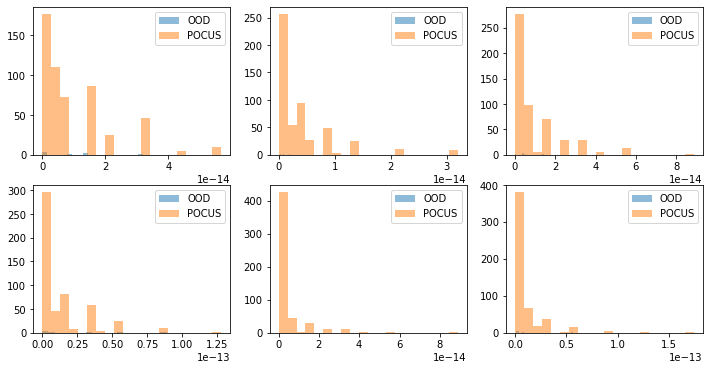

In [ ]:
# plot the epistemic uncertainties for the OOD test set and the POCUS test set and label by which set they belong to
fig = plt.figure(figsize=(12,6))
rows, cols = 2,3

columns = ['epi_norm_0', 'epi_norm_1', 'epi_norm_2', 'epi_soft_0', 'epi_soft_1', 'epi_soft_2']

for col in columns:
    fig.add_subplot(rows, cols, columns.index(col)+1)
    plt.hist(df_OOD[col], bins=20, alpha=0.5, label='OOD')
    plt.hist(df_POCUS[col], bins=20, alpha=0.5, label='POCUS')
    plt.legend()




In [ ]:
print("POCUS min and max for mean and std")
print(min(df_POCUS[col]))
print(max(df_POCUS[col]))
print(np.mean(df_POCUS[col]))
print(np.std(df_POCUS[col]))
print("OOD min and max for mean and std")
print(min(df_OOD[col]))
print(max(df_OOD[col]))
print(np.mean(df_OOD[col]))
print(np.std(df_OOD[col]))

POCUS min and max for mean and std
0.0
1.2789769243681803e-13
9.623795223191386e-15
1.6225263388164497e-14
OOD min and max for mean and std
1.9984014443252818e-15
8.881784197001252e-14
2.245426067304379e-14
2.7711895820604904e-14


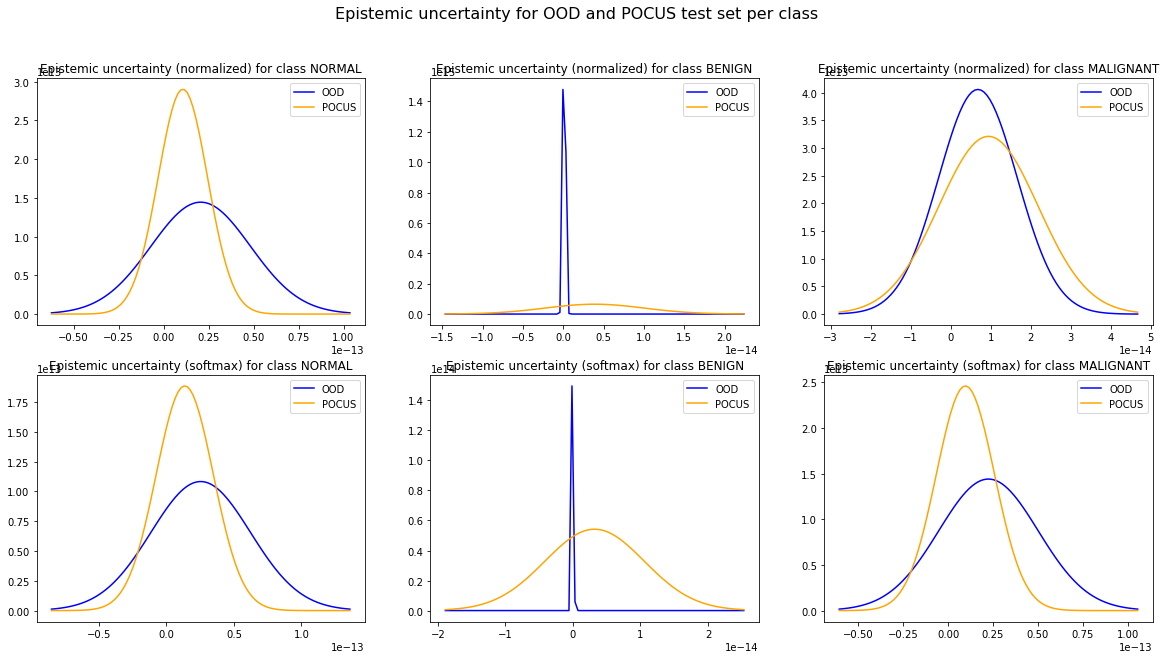

In [ ]:
from scipy.stats import norm
import scipy.stats as stats
fig = plt.figure(figsize=(20,10))
rows, cols = 2,3

columns = ['epi_norm_0', 'epi_norm_1', 'epi_norm_2', 'epi_soft_0', 'epi_soft_1', 'epi_soft_2']
titles = ['Epistemic uncertainty (normalized) for class NORMAL', 'Epistemic uncertainty (normalized) for class BENIGN', 'Epistemic uncertainty (normalized) for class MALIGNANT','Epistemic uncertainty (softmax) for class NORMAL','Epistemic uncertainty (softmax) for class BENIGN','Epistemic uncertainty (softmax) for class MALIGNANT']

for i, col in enumerate(columns):
    # plot normal distribution with mean and std values from the column 
    fig.add_subplot(rows, cols, columns.index(col)+1)

    mu_POCUS = np.mean(df_POCUS[col])
    sigma_POCUS = np.std(df_POCUS[col])
    mu_OOD = np.mean(df_OOD[col])
    sigma_OOD = np.std(df_OOD[col])

    x_axis = np.linspace(min(mu_POCUS-3*sigma_POCUS, mu_OOD-3*sigma_OOD), max(mu_POCUS+3*sigma_POCUS, mu_OOD+3*sigma_OOD), 100)


    plt.plot(x_axis, stats.norm.pdf(x_axis,np.mean(df_OOD[col]), np.std(df_OOD[col])), label='OOD', color='blue')
    plt.plot(x_axis, stats.norm.pdf(x_axis,np.mean(df_POCUS[col]), np.std(df_POCUS[col])), label='POCUS', color='orange')
    plt.legend()
    plt.title(titles[i])

fig.suptitle('Epistemic uncertainty for OOD and POCUS test set per class', fontsize=16) 
plt.show()

min:  0.0
max:  8.881784197001252e-14
mean:  2.0539125955565396e-14
std:  2.74526071769891e-14
mean:  1.2785441413541102e-14
std:  1.5070877759735396e-14
min:  0.0
max:  1.7408297026122455e-13
mean:  4.529709940470639e-14
std:  3.4843320313423035e-14
mean:  1.9964778325020673e-14
std:  2.3981911698471234e-14


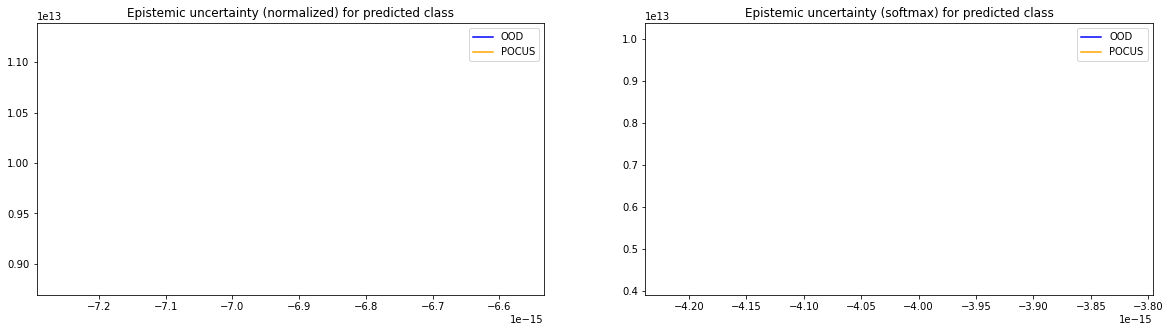

In [ ]:
columns = ['epi_norm_pred', 'epi_soft_pred']
titles = ['Epistemic uncertainty (normalized) for predicted class', 'Epistemic uncertainty (softmax) for predicted class']
fig = plt.figure(figsize=(20,5))
rows, cols = 1,2

for i, col in enumerate(columns):
    # plot normal distribution with mean and std values from the column 
    fig.add_subplot(rows, cols, columns.index(col)+1)
    x_axis = np.arange(min(np.mean(df_OOD[col]) - np.std(df_OOD[col]),np.mean(df_POCUS[col]) - np.std(df_POCUS[col])), max(np.mean(df_OOD[col]) + np.std(df_OOD[col]),np.mean(df_POCUS[col]) + np.std(df_POCUS[col])), 0.001)
    print("min: ", min(min(df_OOD[col]), min(df_POCUS[col])))   
    print("max: ", max(max(df_OOD[col]),max(df_POCUS[col])))
    print("mean: ", np.mean(df_OOD[col]))
    print("std: ", np.std(df_OOD[col]))
    print("mean: ", np.mean(df_POCUS[col]))
    print("std: ", np.std(df_POCUS[col]))

    plt.plot(x_axis, norm.pdf(x_axis,np.mean(df_OOD[col]), np.std(df_OOD[col])), label='OOD', color='blue')
    plt.plot(x_axis, norm.pdf(x_axis,np.mean(df_POCUS[col]), np.std(df_POCUS[col])), label='POCUS', color='orange')
    plt.legend()
    plt.title(titles[i])

plt.show()

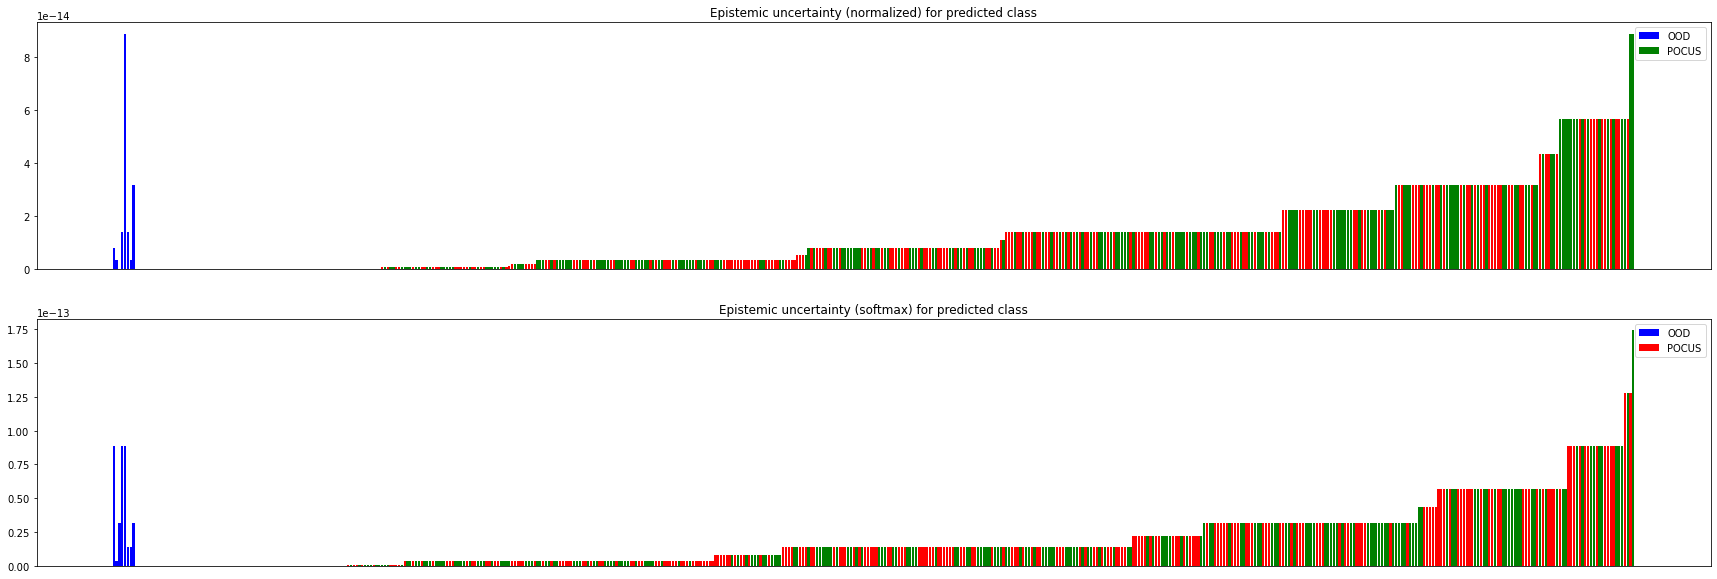

In [ ]:
columns = ['epi_norm_pred', 'epi_soft_pred']
titles = ['Epistemic uncertainty (normalized) for predicted class', 'Epistemic uncertainty (softmax) for predicted class']
fig = plt.figure(figsize=(30, 10))
rows, cols = 2,1

for i, col in enumerate(columns):
    # plot normal distribution with mean and std values from the column 
    fig.add_subplot(rows, cols, columns.index(col)+1)

    x_axis_OOD = [f'OOD_{str(elem)}' for elem in np.arange(1, len(df_OOD)+1, 1)]
    x_axis_POCUS = [f'POCUS_{str(elem)}' for elem in np.arange(1, len(df_POCUS)+1, 1)]

    x_axis = x_axis_OOD + x_axis_POCUS

    colordict = dict(zip([True, False], ['green', 'red']))

    df_dummy = df_POCUS.sort_values(col)

    plt.bar(x_axis_OOD, df_OOD[col], label='OOD', color='blue')
    plt.bar(x_axis_POCUS, df_dummy[col], label='POCUS', color=df_dummy['correct'].apply(lambda x: colordict[x]))

    plt.xticks([])
    plt.legend()
    plt.title(titles[i])

plt.show()

TODO: Add a horizontal line at a good cut off value

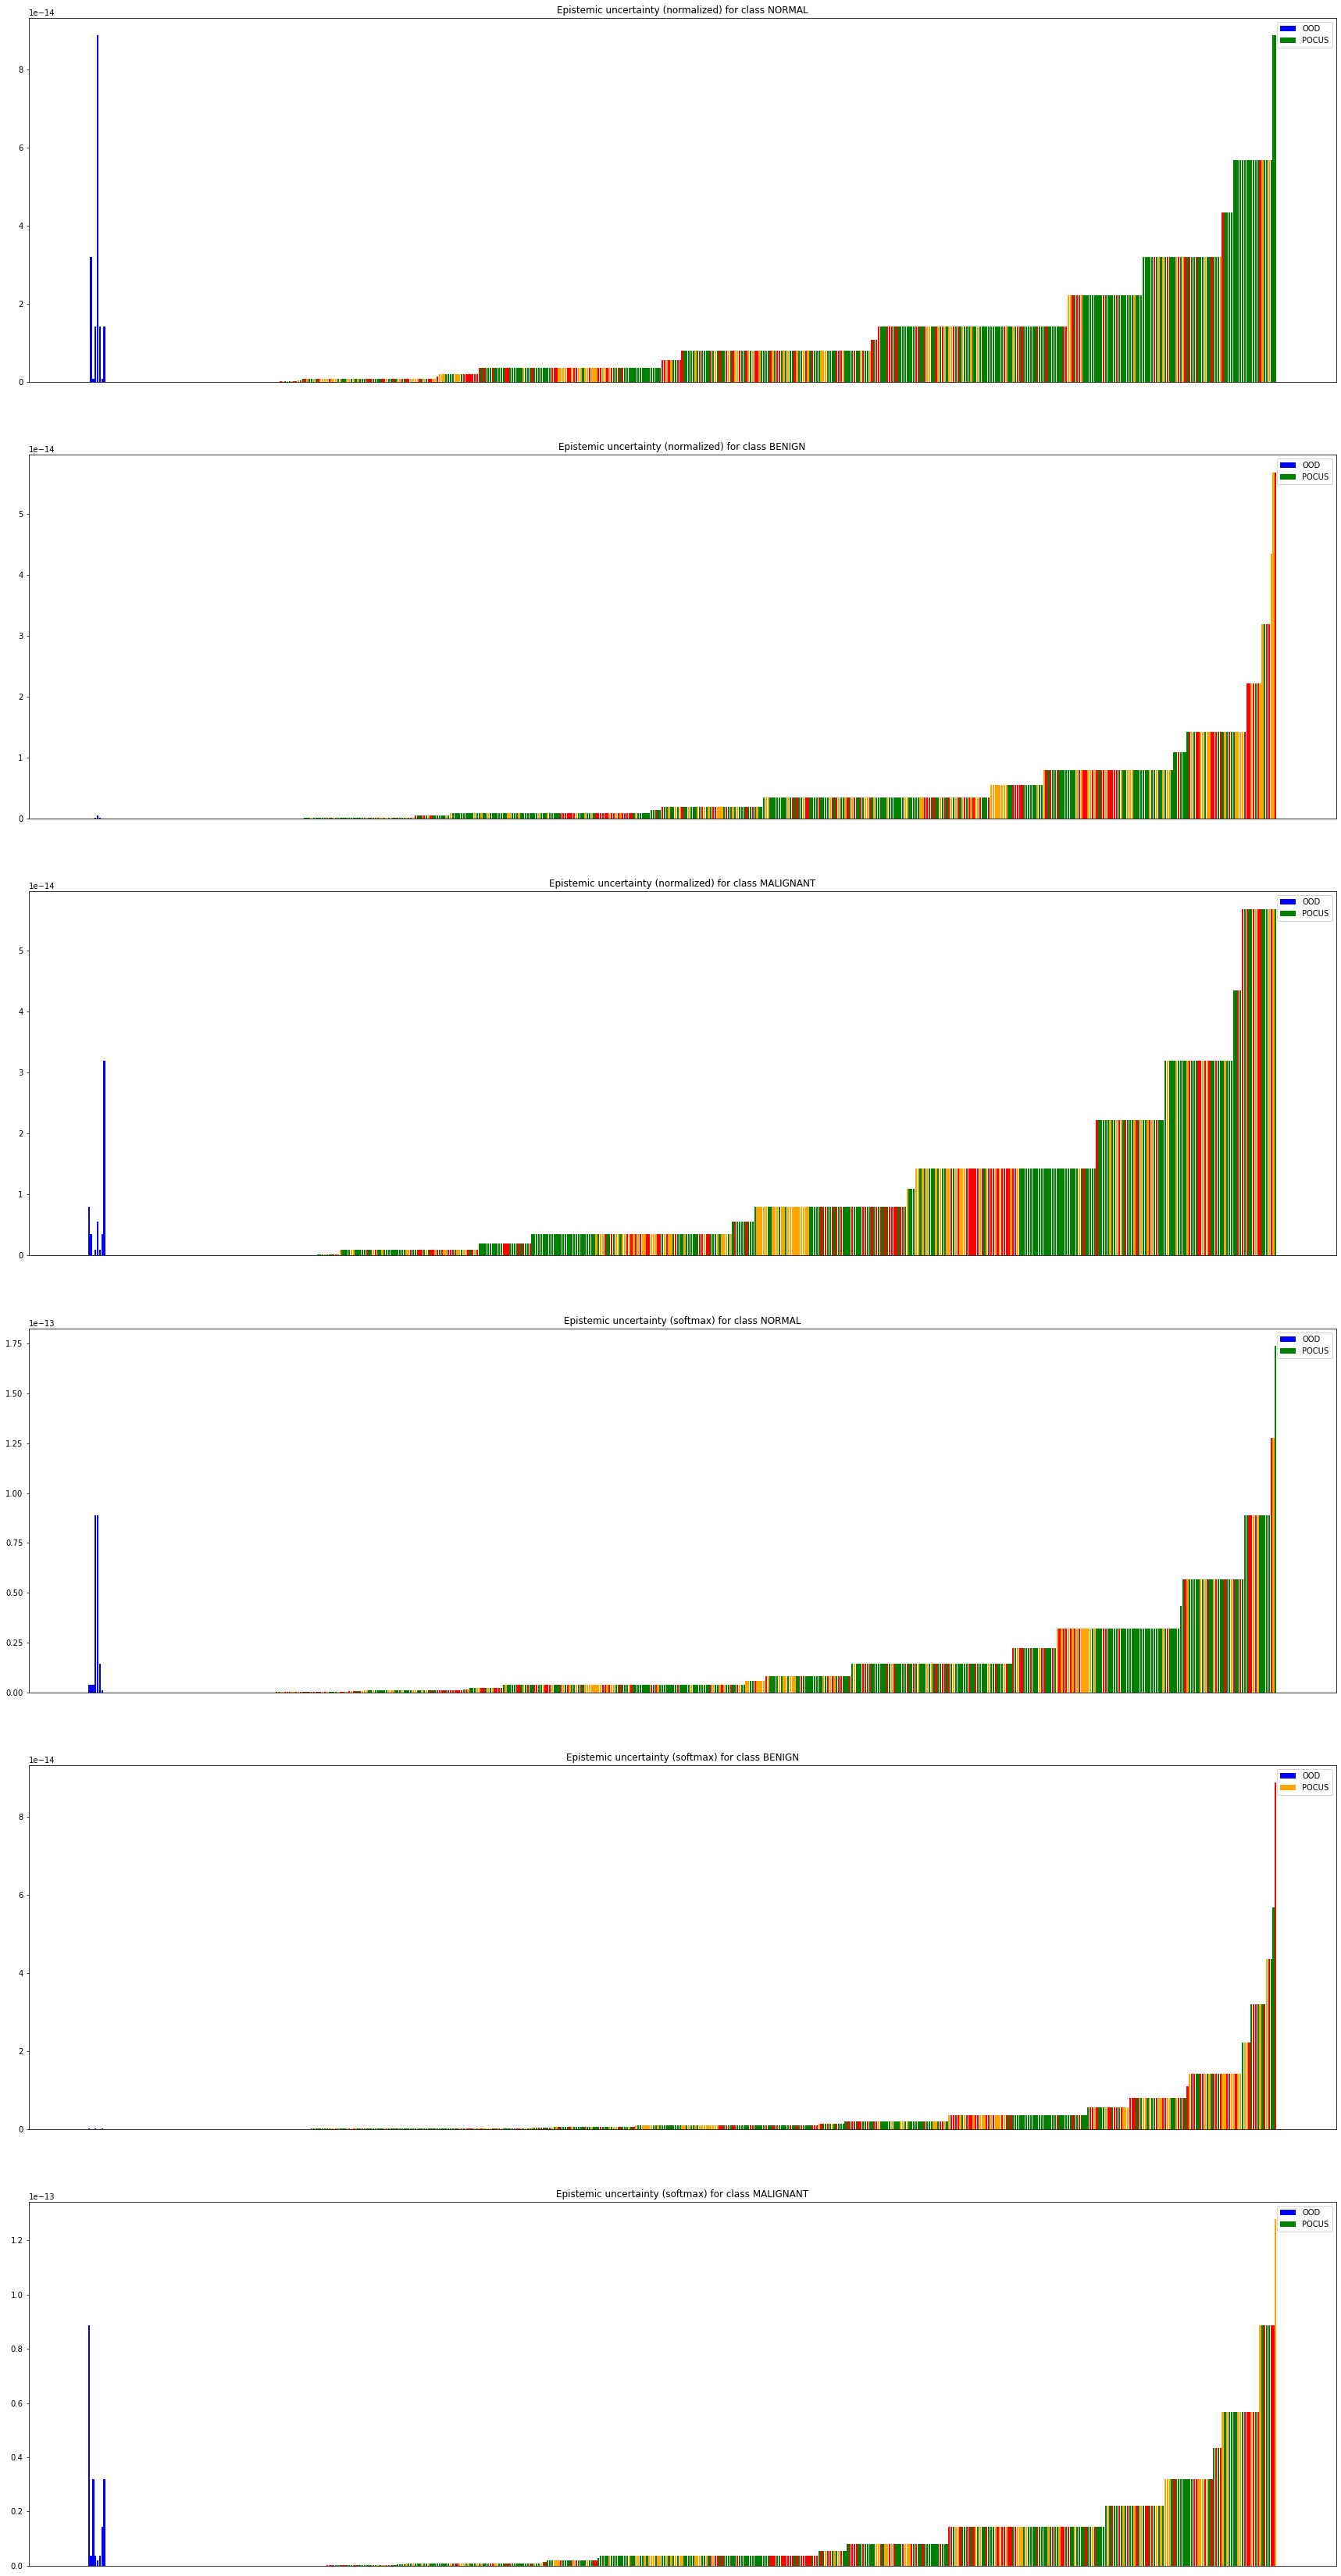

In [ ]:
columns = ['epi_norm_0', 'epi_norm_1', 'epi_norm_2', 'epi_soft_0', 'epi_soft_1', 'epi_soft_2']
titles = ['Epistemic uncertainty (normalized) for class NORMAL', 'Epistemic uncertainty (normalized) for class BENIGN', 'Epistemic uncertainty (normalized) for class MALIGNANT','Epistemic uncertainty (softmax) for class NORMAL','Epistemic uncertainty (softmax) for class BENIGN','Epistemic uncertainty (softmax) for class MALIGNANT']

fig = plt.figure(figsize=(30, 60))
rows, cols = 6,1

for i, col in enumerate(columns):
    # plot normal distribution with mean and std values from the column 
    fig.add_subplot(rows, cols, columns.index(col)+1)

    x_axis_OOD = [f'OOD_{str(elem)}' for elem in np.arange(1, len(df_OOD)+1, 1)]
    x_axis_POCUS = [f'POCUS_{str(elem)}' for elem in np.arange(1, len(df_POCUS)+1, 1)]

    x_axis = x_axis_OOD + x_axis_POCUS

    colordict = dict(zip([0, 1, 2], ['green', 'red', 'orange']))

    df_dummy = df_POCUS.sort_values(col)

    plt.bar(x_axis_OOD, df_OOD[col], label='OOD', color='blue')
    plt.bar(x_axis_POCUS, df_dummy[col], label='POCUS', color=df_dummy['truth'].apply(lambda x: colordict[x]))

    plt.xticks([])
    plt.legend()
    plt.title(titles[i])

plt.show()



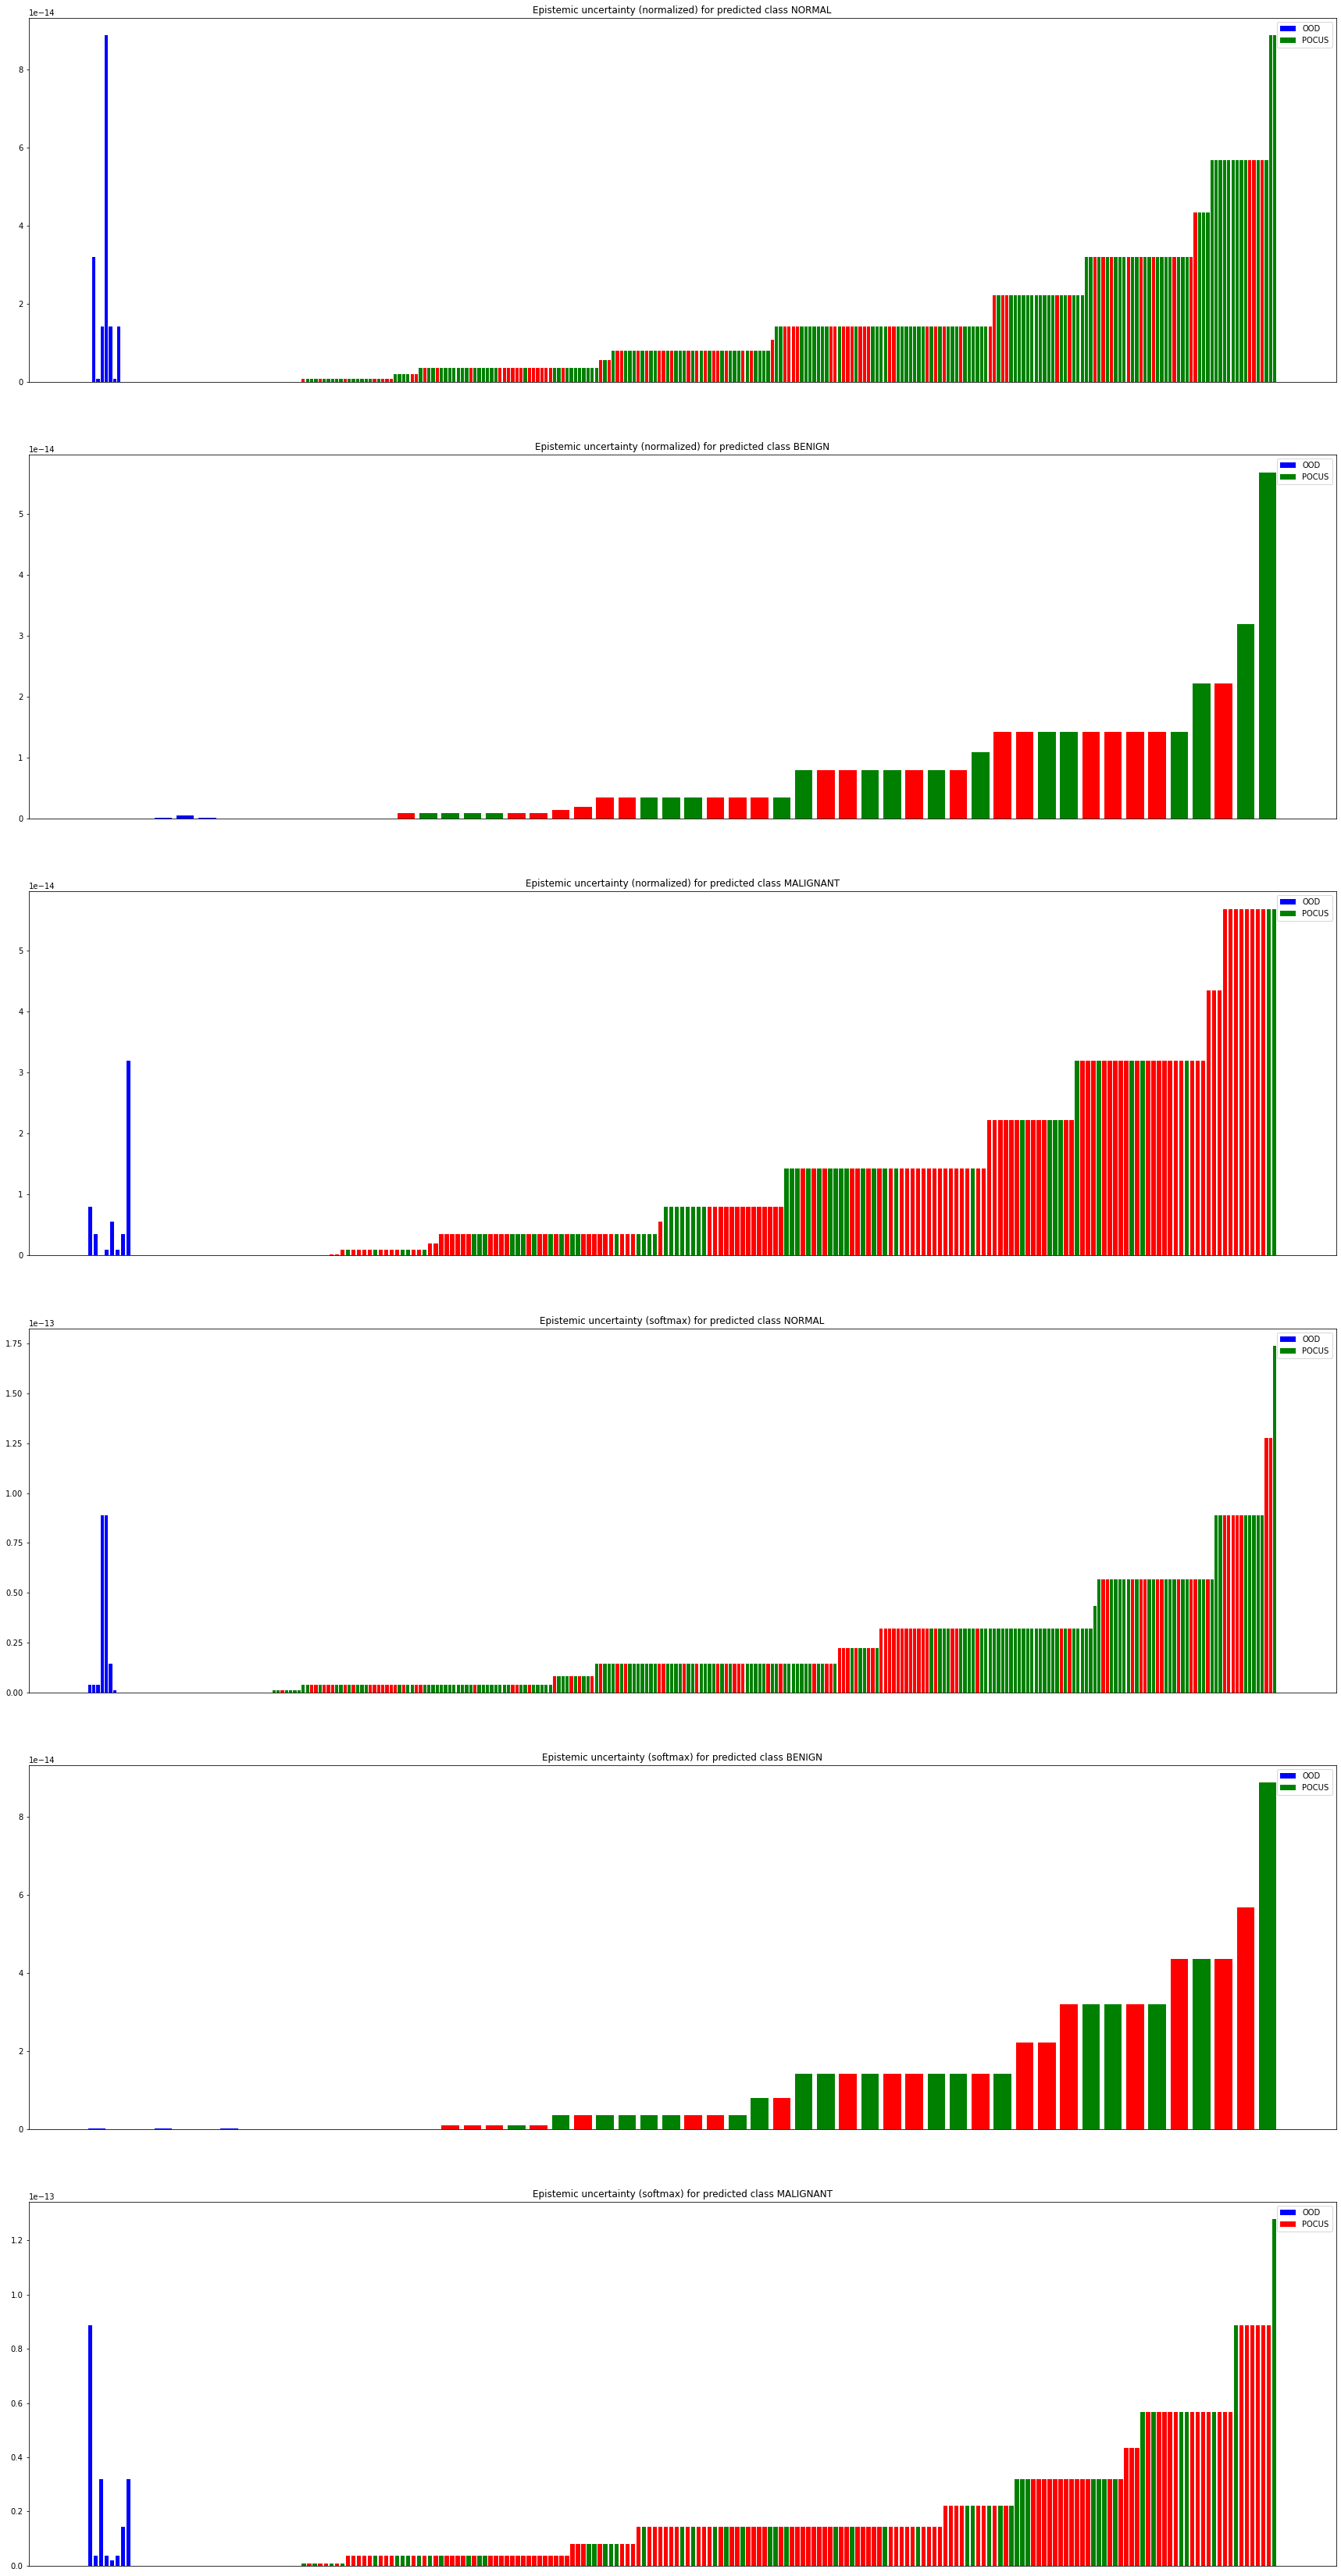

In [ ]:
# per class, but only if that one was predicted 

columns = ['epi_norm_0', 'epi_norm_1', 'epi_norm_2', 'epi_soft_0', 'epi_soft_1', 'epi_soft_2']
titles = ['Epistemic uncertainty (normalized) for predicted class NORMAL', 'Epistemic uncertainty (normalized) for predicted class BENIGN', 'Epistemic uncertainty (normalized) for predicted class MALIGNANT','Epistemic uncertainty (softmax) for predicted class NORMAL','Epistemic uncertainty (softmax) for predicted class BENIGN','Epistemic uncertainty (softmax) for predicted class MALIGNANT']

fig = plt.figure(figsize=(30, 60))
rows, cols = 6,1

for i, col in enumerate(columns):
    # plot normal distribution with mean and std values from the column 
    fig.add_subplot(rows, cols, columns.index(col)+1)

    df_dummy = df_POCUS.sort_values(col)
    df_dummy = df_dummy[df_dummy['pred'] == i % 3]

    x_axis_OOD = [f'OOD_{str(elem)}' for elem in np.arange(1, len(df_OOD)+1, 1)]
    x_axis_POCUS = [f'POCUS_{str(elem)}' for elem in np.arange(1, len(df_dummy)+1, 1)]

    x_axis = x_axis_OOD + x_axis_POCUS

    colordict = dict(zip([True, False], ['green', 'red']))

    plt.bar(x_axis_OOD, df_OOD[col], label='OOD', color='blue')
    plt.bar(x_axis_POCUS, df_dummy[col], label='POCUS', color=df_dummy['correct'].apply(lambda x: colordict[x]))

    plt.xticks([])
    plt.legend()
    plt.title(titles[i])

plt.show()



# STUFF FOR ISBI